# 📊 GSFL Wireless Simulation + SL vs GSFL + Confusion Matrices
This notebook visualizes:
- SL vs GSFL Accuracy
- Loss, Communication, Compute Comparisons
- Wireless Bandwidth Simulation
- Confusion Matrices


In [2]:
import json, os
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
from gsfl.data import get_test_loader
from gsfl.models import ClientNet, ServerNet
from gsfl.sim.wireless_config import CLIENT_DISTANCES, CLIENT_TECH
from gsfl.sim.comm import compute_bandwidth


In [3]:
# Load SL and GSFL results
sl = json.load(open('results/sl_results.json'))
gsfl = json.load(open('results/gsfl_results.json'))

rounds_sl = range(1, len(sl['accuracy'])+1)
rounds_gsfl = range(1, len(gsfl['accuracy'])+1)

print("Metrics loaded successfully.")


Metrics loaded successfully.


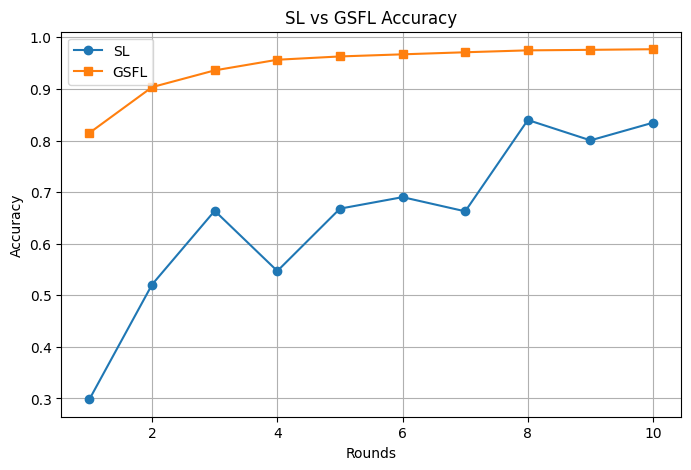

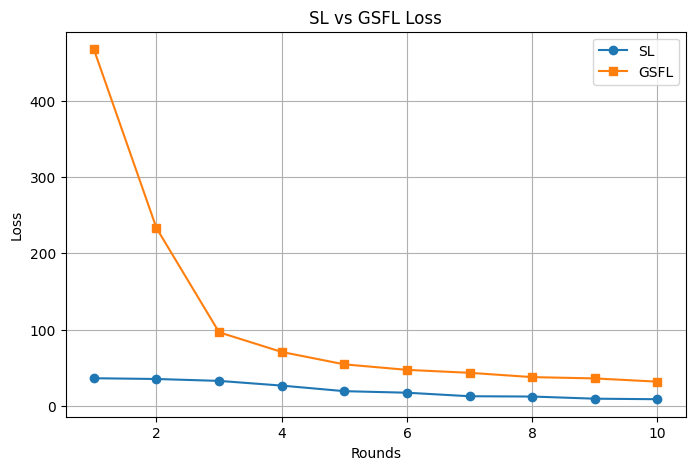

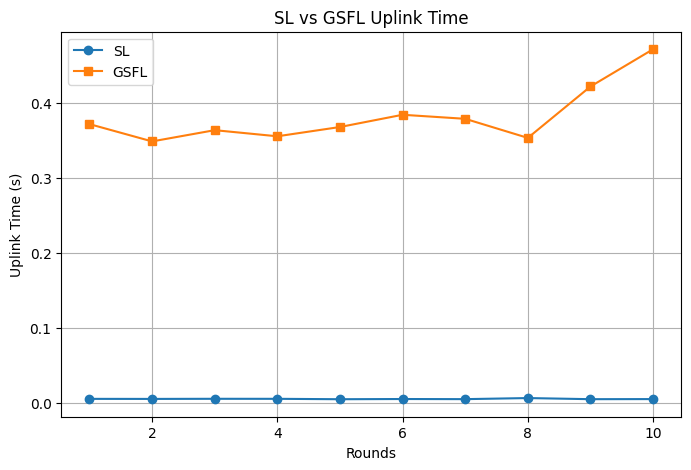

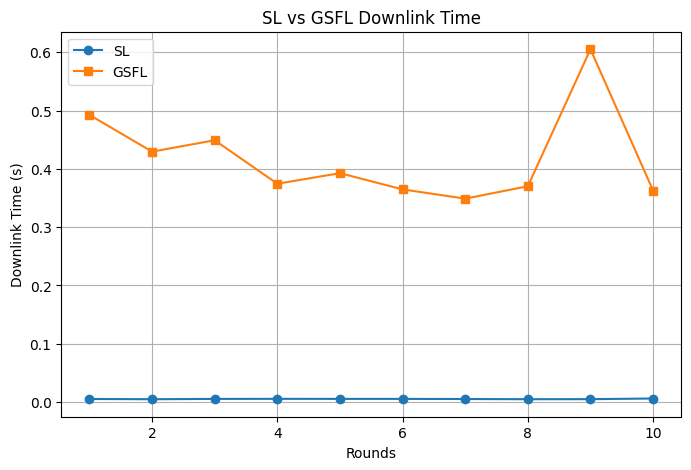

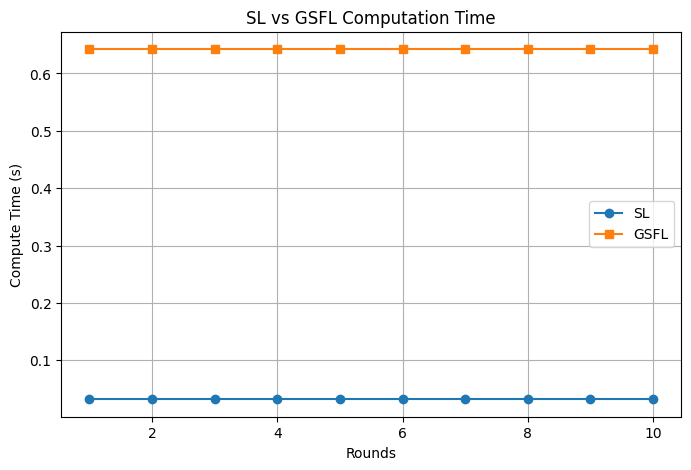

In [4]:
def plot_metric(sl_val, gsfl_val, ylabel, title):
    plt.figure(figsize=(8,5))
    plt.plot(list(rounds_sl), sl_val, label="SL", marker="o")
    plt.plot(list(rounds_gsfl), gsfl_val, label="GSFL", marker="s")
    plt.xlabel("Rounds")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_metric(sl['accuracy'], gsfl['accuracy'], "Accuracy", "SL vs GSFL Accuracy")
plot_metric(sl['loss'], gsfl['loss'], "Loss", "SL vs GSFL Loss")
plot_metric(sl['uplink'], gsfl['uplink'], "Uplink Time (s)", "SL vs GSFL Uplink Time")
plot_metric(sl['downlink'], gsfl['downlink'], "Downlink Time (s)", "SL vs GSFL Downlink Time")
plot_metric(sl['compute'], gsfl['compute'], "Compute Time (s)", "SL vs GSFL Computation Time")


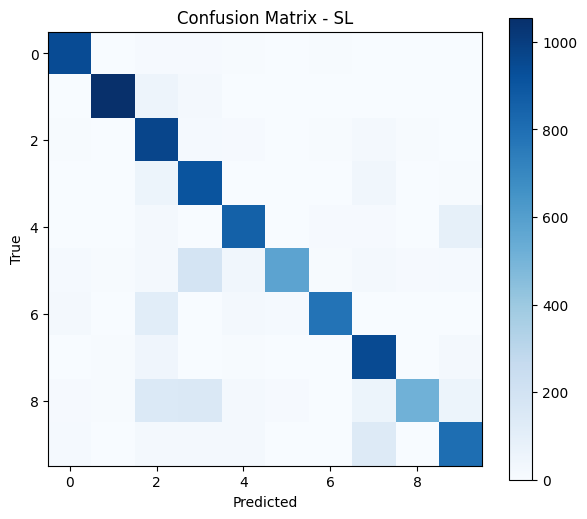

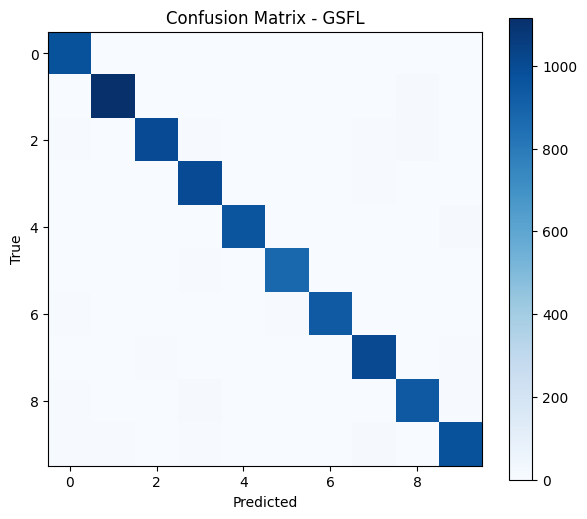

In [5]:
# Confusion matrix support
def load_model(client_path, server_path):
    client = ClientNet()
    server = ServerNet()
    client.load_state_dict(torch.load(client_path, map_location='cpu'))
    server.load_state_dict(torch.load(server_path, map_location='cpu'))
    return client, server

def evaluate_predictions(client, server, loader):
    client.eval(); server.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            out = server(client(X))
            preds = out.argmax(dim=1)
            y_true.extend(y.numpy())
            y_pred.extend(preds.numpy())
    return np.array(y_true), np.array(y_pred)

test_loader = get_test_loader()

sl_client, sl_server = load_model("results/sl_client.pt", "results/sl_server.pt")
gsfl_client, gsfl_server = load_model("results/gsfl_client.pt", "results/gsfl_server.pt")

y_true_sl, y_pred_sl = evaluate_predictions(sl_client, sl_server, test_loader)
y_true_gsfl, y_pred_gsfl = evaluate_predictions(gsfl_client, gsfl_server, test_loader)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(y_true_sl, y_pred_sl, "Confusion Matrix - SL")
plot_cm(y_true_gsfl, y_pred_gsfl, "Confusion Matrix - GSFL")


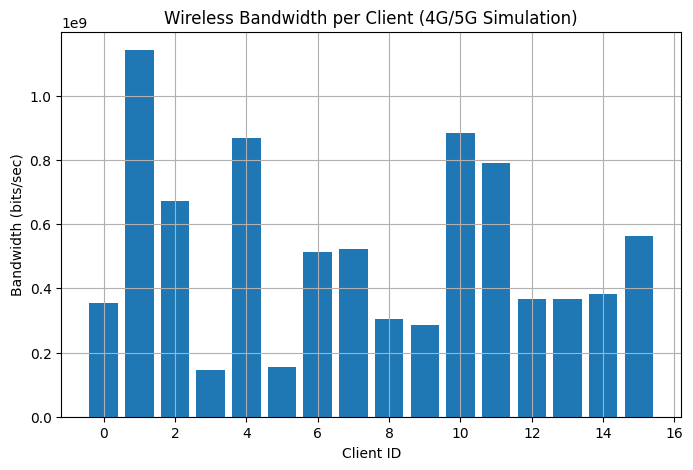

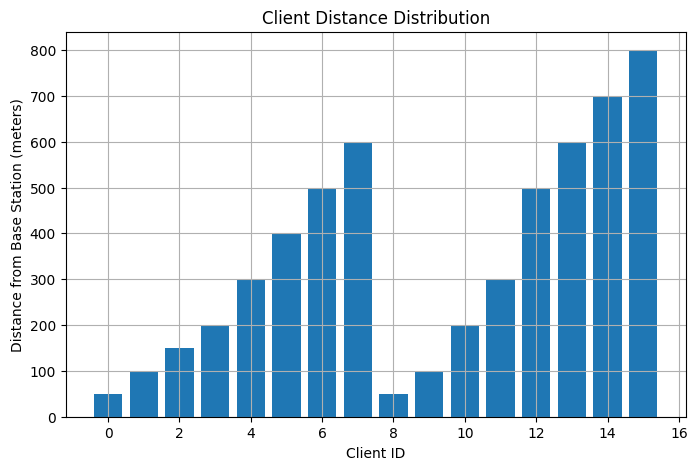

In [6]:
# Wireless bandwidth visualization
bw_values = [compute_bandwidth(cid) for cid in CLIENT_DISTANCES]

plt.figure(figsize=(8,5))
plt.bar(range(len(bw_values)), bw_values)
plt.xlabel("Client ID")
plt.ylabel("Bandwidth (bits/sec)")
plt.title("Wireless Bandwidth per Client (4G/5G Simulation)")
plt.grid(True)
plt.show()

# Plot distances
plt.figure(figsize=(8,5))
plt.bar(CLIENT_DISTANCES.keys(), CLIENT_DISTANCES.values())
plt.xlabel("Client ID")
plt.ylabel("Distance from Base Station (meters)")
plt.title("Client Distance Distribution")
plt.grid(True)
plt.show()
